In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('./dataset/df_processed.csv')
df.drop(['id','comment_text','comment_lower','has_apostrophe','has_new_line'], axis=1, inplace=True)
df.rename(columns={'com_processed':'join_tokens'}, inplace=True)

In [10]:
df['negative_comments'] = df['label_sum'].apply(lambda x:int(x>0))
df[5:8]

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
5,0,0,0,0,0,0,0,congratulations well use tools well talk,0
6,1,1,1,0,1,0,4,cocksucker piss around work,1
7,0,0,0,0,0,0,0,vandalism matt shirvington article reverted pl...,0


In [3]:
def binary(inp):
    if inp == 0: out = 0
    else: out = 1
    return out

df['negative_comments'] = df['label_sum'].apply(binary)

df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
0,0,0,0,0,0,0,0,explanation edits made username hardcore metal...,0
1,0,0,0,0,0,0,0,aww matches background colour seemingly stuck ...,0
2,0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...,0
3,0,0,0,0,0,0,0,make real suggestions improvement wondered sec...,0
4,0,0,0,0,0,0,0,sir hero chance remember page,0


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,negative_comments
count,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000
mean,0.095881,0.009999,0.052968,0.002997,0.049382,0.008808,0.220035,0.101717
std,0.294428,0.099496,0.223971,0.054660,0.216665,0.093438,0.748388,0.302277
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


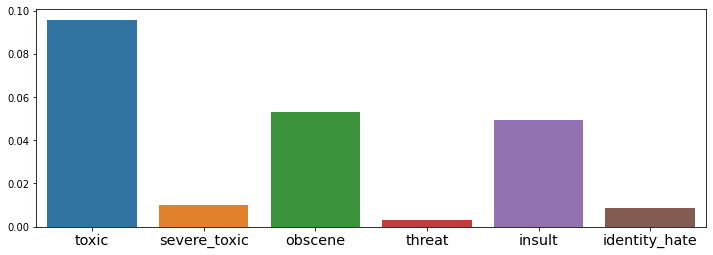

In [11]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

class_sum = [df[col].sum()/len(df) for col in target_columns]

fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.barplot(x=target_columns, y=class_sum, ax=ax)
ax.set_xticklabels(target_columns, fontsize='x-large');

# Undersampling for prototyping

In [6]:
#df = df.sample(frac=0.5, random_state=101)

# Splitting into train and test set with stratification

In [12]:
test_size_0 = int(0.2 * len(df[df.negative_comments == 0]))
test_size_1 = int(0.2 * len(df[df.negative_comments == 1]))

In [13]:
df_test_0 = df[df.negative_comments == 0].sample(n=test_size_0, random_state=101)
df_test_1 = df[df.negative_comments == 1].sample(n=test_size_1, random_state=101)
df_test   = df_test_0.append(df_test_1)
df_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
26349,0,0,0,0,0,0,0,internet media shreveport tag placed internet ...,0
13063,0,0,0,0,0,0,0,yes disqualifications baseless ever supported ...,0
119707,0,0,0,0,0,0,0,ref go onto tube type tna video game angle v s...,0
41466,0,0,0,0,0,0,0,thanks sorry seen previous versions good faith...,0
113955,0,0,0,0,0,0,0,announced playstation kingdom hearts iii please,0


In [14]:
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
df_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
1,0,0,0,0,0,0,0,aww matches background colour seemingly stuck ...,0
2,0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...,0
3,0,0,0,0,0,0,0,make real suggestions improvement wondered sec...,0
4,0,0,0,0,0,0,0,sir hero chance remember page,0
6,1,1,1,0,1,0,4,cocksucker piss around work,1


In [15]:
df_train.negative_comments.sum()/len(df_train)

0.10235261335137932

In [16]:
df_test.negative_comments.sum()/len(df_test)

0.10171776064196603

In [17]:
del df
del df_test_0
del df_test_1

# TF-IDF

In [18]:
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)

tfidf_train = vectorizer.fit_transform(df_train.join_tokens.values)

In [19]:
tfidf_test = vectorizer.transform(df_test.join_tokens.values).toarray()

# Modeling

### Recap metrics for all models

In [20]:
recap_binary_precision = []
recap_binary_recall    = []
recap_mean_precision   = []
recap_mean_recall      = []

## Baseline model: Direct multilabel classification with logistic regression

In [21]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [22]:
def mean_metrics(clf, X, y):
    pred = clf.predict(X)
    prec, rec, fs, _ = precision_recall_fscore_support(y, pred)
    print('mean precision: %.2f' % np.mean(prec))
    print('mean recall: %.2f' % np.mean(rec))
    print('mean f-score: %.2f' % np.mean(fs))
    return pred, np.mean(prec), np.mean(rec)

In [23]:
mlc_base = MultiOutputClassifier(LogisticRegression())
mlc_base.fit(tfidf_train, df_train[target_columns])

MultiOutputClassifier(estimator=LogisticRegression())

In [24]:
print('Metrics for training data set')
y_pred_train, prec_train, rec_train = mean_metrics(mlc_base, tfidf_train, df_train[target_columns])

Metrics for training data set
mean precision: 0.82
mean recall: 0.39
mean f-score: 0.51


In [25]:
print('Metrics for test data set')
y_pred_test, prec_test, rec_test = mean_metrics(mlc_base, tfidf_test, df_test[target_columns])
recap_mean_precision.append(prec_test)
recap_mean_recall.append(rec_test)

Metrics for test data set
mean precision: 0.75
mean recall: 0.39
mean f-score: 0.49


### This is metric to assess how good we can capture negative comments, irrespective of labels

In [26]:
def binary_metric(y_true, y_pred):
    pred_binary = np.array([1 if x > 0 else 0 for x in y_pred.sum(axis=1)])
    prec, rec, fs, _ = precision_recall_fscore_support(df_test['negative_comments'], pred_binary)
    print('precision: %.2f' % prec[1])
    print('recall: %.2f' % rec[1])
    print('f-score: %.2f' % fs[1])
    return pred_binary, prec[1], rec[1]

In [22]:
print('Metric for binary class 1')
pred_binary, prec_binary, rec_binary = binary_metric(df_test['negative_comments'], y_pred_test)
recap_binary_precision.append(prec_binary)
recap_binary_recall.append(rec_binary)

Metric for binary class 1
precision: 0.95
recall: 0.58
f-score: 0.72


## Upgraded model (1): Baseline model + CV + Balanced weight in loss function + f-score optimizer

In [23]:
custom_score = make_scorer(f1_score, average='micro')

lr = LogisticRegression(class_weight='balance')

gcv = GridSearchCV(estimator = lr,
                   param_grid = {},
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

mlc_1 = MultiOutputClassifier(gcv)

mlc_1.fit(tfidf_train, df_train[target_columns])

MultiOutputClassifier(estimator=GridSearchCV(cv=3,
                                             estimator=LogisticRegression(class_weight='balance'),
                                             n_jobs=-1, param_grid={},
                                             scoring=make_scorer(f1_score, average=micro)))

In [24]:
print('Metrics for training data set')
y_pred_train, prec_train, rec_train = mean_metrics(mlc_1, tfidf_train, df_train[target_columns])

Metrics for training data set
mean precision: 0.82
mean recall: 0.39
mean f-score: 0.51


In [25]:
print('Metrics for test data set')
y_pred_test, prec_test, rec_test = mean_metrics(mlc_1, tfidf_test, df_test[target_columns])
recap_mean_precision.append(prec_test)
recap_mean_recall.append(rec_test)

Metrics for test data set
mean precision: 0.75
mean recall: 0.39
mean f-score: 0.49


In [26]:
print('Metric for binary class 1')
pred_binary, prec_binary, rec_binary = binary_metric(df_test['negative_comments'], y_pred_test)
recap_binary_precision.append(prec_binary)
recap_binary_recall.append(rec_binary)

Metric for binary class 1
precision: 0.95
recall: 0.58
f-score: 0.72


## Upgraded model (2): Model 1 + grid search for class weight

In [27]:
custom_score = make_scorer(f1_score, average='micro')

weights = [0.05,0.10,0.15,0.20,0.25]
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression()

gcv = GridSearchCV(estimator = lr,
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

mlc_2 = MultiOutputClassifier(gcv)

mlc_2.fit(tfidf_train, df_train[target_columns])

MultiOutputClassifier(estimator=GridSearchCV(cv=3,
                                             estimator=LogisticRegression(),
                                             n_jobs=-1,
                                             param_grid={'class_weight': [{0: 0.05,
                                                                           1: 0.95},
                                                                          {0: 0.1,
                                                                           1: 0.9},
                                                                          {0: 0.15,
                                                                           1: 0.85},
                                                                          {0: 0.2,
                                                                           1: 0.8},
                                                                          {0: 0.25,
                                                            

In [28]:
print('Metrics for training data set')
y_pred_train, prec_train, rec_train = mean_metrics(mlc_2, tfidf_train, df_train[target_columns])

Metrics for training data set
mean precision: 0.71
mean recall: 0.52
mean f-score: 0.58


In [29]:
print('Metrics for test data set')
y_pred_test, prec_test, rec_test = mean_metrics(mlc_2, tfidf_test, df_test[target_columns])
recap_mean_precision.append(prec_test)
recap_mean_recall.append(rec_test)

Metrics for test data set
mean precision: 0.65
mean recall: 0.49
mean f-score: 0.55


In [30]:
print('Metric for binary class 1')
pred_binary, prec_binary, rec_binary = binary_metric(df_test['negative_comments'], y_pred_test)
recap_binary_precision.append(prec_binary)
recap_binary_recall.append(rec_binary)

Metric for binary class 1
precision: 0.87
recall: 0.68
f-score: 0.76


## Upgraded model (3): Model 2 + hyperparameter tuning for C

In [31]:
custom_score = make_scorer(f1_score, average='micro')

weights = [0.05,0.10,0.15,0.20,0.25]
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights],
              'C': [1, 10, 100]}

lr = LogisticRegression()

gcv = GridSearchCV(estimator = lr,
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

mlc_3 = MultiOutputClassifier(gcv)

mlc_3.fit(tfidf_train, df_train[target_columns])

/Users/dutomo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dutomo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

MultiOutputClassifier(estimator=GridSearchCV(cv=3,
                                             estimator=LogisticRegression(),
                                             n_jobs=-1,
                                             param_grid={'C': [1, 10, 100],
                                                         'class_weight': [{0: 0.05,
                                                                           1: 0.95},
                                                                          {0: 0.1,
                                                                           1: 0.9},
                                                                          {0: 0.15,
                                                                           1: 0.85},
                                                                          {0: 0.2,
                                                                           1: 0.8},
                                                                    

In [32]:
print('Metrics for training data set')
y_pred_train, prec_train, rec_train = mean_metrics(mlc_3, tfidf_train, df_train[target_columns])

Metrics for training data set
mean precision: 0.81
mean recall: 0.82
mean f-score: 0.81


In [33]:
print('Metrics for test data set')
y_pred_test, prec_test, rec_test = mean_metrics(mlc_3, tfidf_test, df_test[target_columns])
recap_mean_precision.append(prec_test)
recap_mean_recall.append(rec_test)

Metrics for test data set
mean precision: 0.63
mean recall: 0.56
mean f-score: 0.58


In [34]:
print('Metric for binary class 1')
pred_binary, prec_binary, rec_binary = binary_metric(df_test['negative_comments'], y_pred_test)
recap_binary_precision.append(prec_binary)
recap_binary_recall.append(rec_binary)

Metric for binary class 1
precision: 0.83
recall: 0.75
f-score: 0.79


## Stacked model: binary classification followed by multilables classification with CV + balanced weight + scoring optimizer

## Binary classification

In [35]:
custom_score = make_scorer(recall_score, average='binary')

weights = [0.05,0.10,0.15,0.20,0.25]
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(max_iter=1000)

gcv_recall = GridSearchCV(estimator = lr,
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

gcv_recall.fit(tfidf_train, df_train['negative_comments'])

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9},
                                          {0: 0.15, 1: 0.85}, {0: 0.2, 1: 0.8},
                                          {0: 0.25, 1: 0.75}]},
             scoring=make_scorer(recall_score, average=binary))

In [36]:
y_pred_test = gcv_recall.predict(tfidf_test)
print('Metric for binary class 1')
prec, rec, fs, _ = precision_recall_fscore_support(df_test['negative_comments'], y_pred_test)
print('precision: %.2f' % prec[1])
print('recall: %.2f' % rec[1])
print('f-score: %.2f' % fs[1])

Metric for binary class 1
precision: 0.38
recall: 0.94
f-score: 0.54


### Focusing on precision for those predicted as 1

In [37]:
custom_score = make_scorer(f1_score, average='binary')

weights = [0.05,0.10,0.15,0.20,0.25]
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(max_iter=1000)

gcv_fs = GridSearchCV(estimator = lr,
                   param_grid = param_grid,
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

gcv_fs.fit(tfidf_train, df_train['negative_comments'])

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9},
                                          {0: 0.15, 1: 0.85}, {0: 0.2, 1: 0.8},
                                          {0: 0.25, 1: 0.75}]},
             scoring=make_scorer(f1_score, average=binary))

In [38]:
negative_index = np.where(y_pred_test == 1)
y_pred_fs = gcv_fs.predict(tfidf_test[negative_index])
print('Metric for binary class 1')
prec, rec, fs, _ = precision_recall_fscore_support(df_test['negative_comments'].to_numpy()[negative_index],
                                                   y_pred_fs)
print('precision: %.2f' % prec[1])
print('recall: %.2f' % rec[1])
print('f-score: %.2f' % fs[1])

Metric for binary class 1
precision: 0.80
recall: 0.79
f-score: 0.80


In [39]:
comb_pred = []
j = 0
for i in range(len(y_pred_test)):
    if y_pred_test[i] == 1:
        comb_pred.append(y_pred_fs[j])
        j += 1
    else:
        comb_pred.append(0)

In [40]:
print('Metric for binary class 1')
prec, rec, fs, _ = precision_recall_fscore_support(df_test['negative_comments'].to_numpy(), comb_pred)
print('precision: %.2f' % prec[1])
print('recall: %.2f' % rec[1])
print('f-score: %.2f' % fs[1])

Metric for binary class 1
precision: 0.80
recall: 0.74
f-score: 0.77


## Multilabel classification for those with class 1

In [41]:
custom_score = make_scorer(f1_score, average='micro')

lr = LogisticRegression(class_weight='balance')

gcv = GridSearchCV(estimator = lr,
                   param_grid = {},
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

mlc_stack = MultiOutputClassifier(gcv)

mlc_stack.fit(tfidf_train, df_train[target_columns].to_numpy())

MultiOutputClassifier(estimator=GridSearchCV(cv=3,
                                             estimator=LogisticRegression(class_weight='balance'),
                                             n_jobs=-1, param_grid={},
                                             scoring=make_scorer(f1_score, average=micro)))

In [42]:
negative_index = np.where(np.array(comb_pred) == 1)
pred = mlc_stack.predict(tfidf_test[negative_index])

In [43]:
#prec, rec, fs, _ = 
precision_recall_fscore_support(df_test[target_columns].to_numpy()[negative_index], pred)
#print('mean precision:', np.mean(prec))
#print('mean recall:', np.mean(rec))
#print('mean f-score:', np.mean(fs))

(array([0.93016194, 0.5408805 , 0.91440678, 0.71428571, 0.8321608 ,
        0.59459459]),
 array([0.79258301, 0.27831715, 0.69838188, 0.18518519, 0.58932384,
        0.18181818]),
 array([0.85587893, 0.36752137, 0.79192661, 0.29411765, 0.69      ,
        0.27848101]),
 array([2319,  309, 1545,   81, 1405,  242]))

In [44]:
pred_binary = np.array([1 if x > 0 else 0 for x in pred.sum(axis=1)])
len(pred_binary[np.where(pred_binary == 0)]) / len(pred_binary)

0.3373493975903614

### Combining binary and multilabel classification

In [45]:
comb_pred_mlc = []
j = 0
for i in range(len(comb_pred)):
    if comb_pred[i] == 1:
        comb_pred_mlc.append(pred[j])
        j += 1
    else:
        comb_pred_mlc.append([0]*6)

In [46]:
print('Metric for binary class 1')
pred_binary, prec_binary, rec_binary = binary_metric(df_test['negative_comments'], np.array(comb_pred_mlc))
recap_binary_precision.append(prec_binary)
recap_binary_recall.append(rec_binary)

Metric for binary class 1
precision: 0.95
recall: 0.58
f-score: 0.72


In [47]:
prec, rec, fs, _ = precision_recall_fscore_support(df_test[target_columns], comb_pred_mlc)
print('mean precision: %.2f' % np.mean(prec))
print('mean recall: %.2f' % np.mean(rec))
print('mean f-score: %.2f' % np.mean(fs))
recap_mean_precision.append(prec)
recap_mean_recall.append(rec)

mean precision: 0.75
mean recall: 0.39
mean f-score: 0.49


# Summary of Metrics

In [48]:
recap_binary_recall

[0.5805855161787365,
 0.5805855161787365,
 0.6761171032357473,
 0.749768875192604,
 0.5805855161787365]

In [49]:
recap_mean_recall

[0.3864441564578567,
 0.3864441564578567,
 0.49484002815232236,
 0.5553101687900349,
 array([0.59869707, 0.26959248, 0.62514484, 0.14563107, 0.52075472,
        0.15884477])]